In [37]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
plt.rcParams.update({'font.size': 22})

In [38]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [39]:
# read Covid-19 SG dataset

sg_data = pd.read_csv(url)

In [40]:
# filter to include only columns A to AD

sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

**Outliers will not be removed because of their importance in the Covid context.**

**No need for scaling as all features are of the same magnitude.**

**Can look into what other features can be included from the current ones through extrapolation.**

In [41]:
sg_data_filtered.head()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
0,2020-01-23,1,NaN,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2,NaN,3,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1,NaN,5,0,0,0,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          645 non-null    object 
 1   Daily Confirmed                               645 non-null    int64  
 2   False Positives Found                         536 non-null    float64
 3   Cumulative Confirmed                          645 non-null    int64  
 4   Daily Discharged                              645 non-null    int64  
 5   Passed but not due to COVID                   645 non-null    int64  
 6   Cumulative Discharged                         645 non-null    int64  
 7   Discharged to Isolation                       645 non-null    int64  
 8   Still Hospitalised                            645 non-null    int64  
 9   Daily Deaths                                  645 non-null    int

In [43]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [44]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [45]:
# change to one-hot dummy for phase

#sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)
sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1)

In [46]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0]) if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0]) if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [47]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [48]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [49]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 41 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               645 non-null    int64  
 1   False Positives Found                         645 non-null    float64
 2   Cumulative Confirmed                          645 non-null    int64  
 3   Daily Discharged                              645 non-null    int64  
 4   Passed but not due to COVID                   645 non-null    int64  
 5   Cumulative Discharged                         645 non-null    int64  
 6   Discharged to Isolation                       645 non-null    int64  
 7   Still Hospitalised                            645 non-null    int64  
 8   Daily Deaths                                  645 non-null    int64  
 9   Cumulative Deaths                             645 non-null    int

<AxesSubplot:>

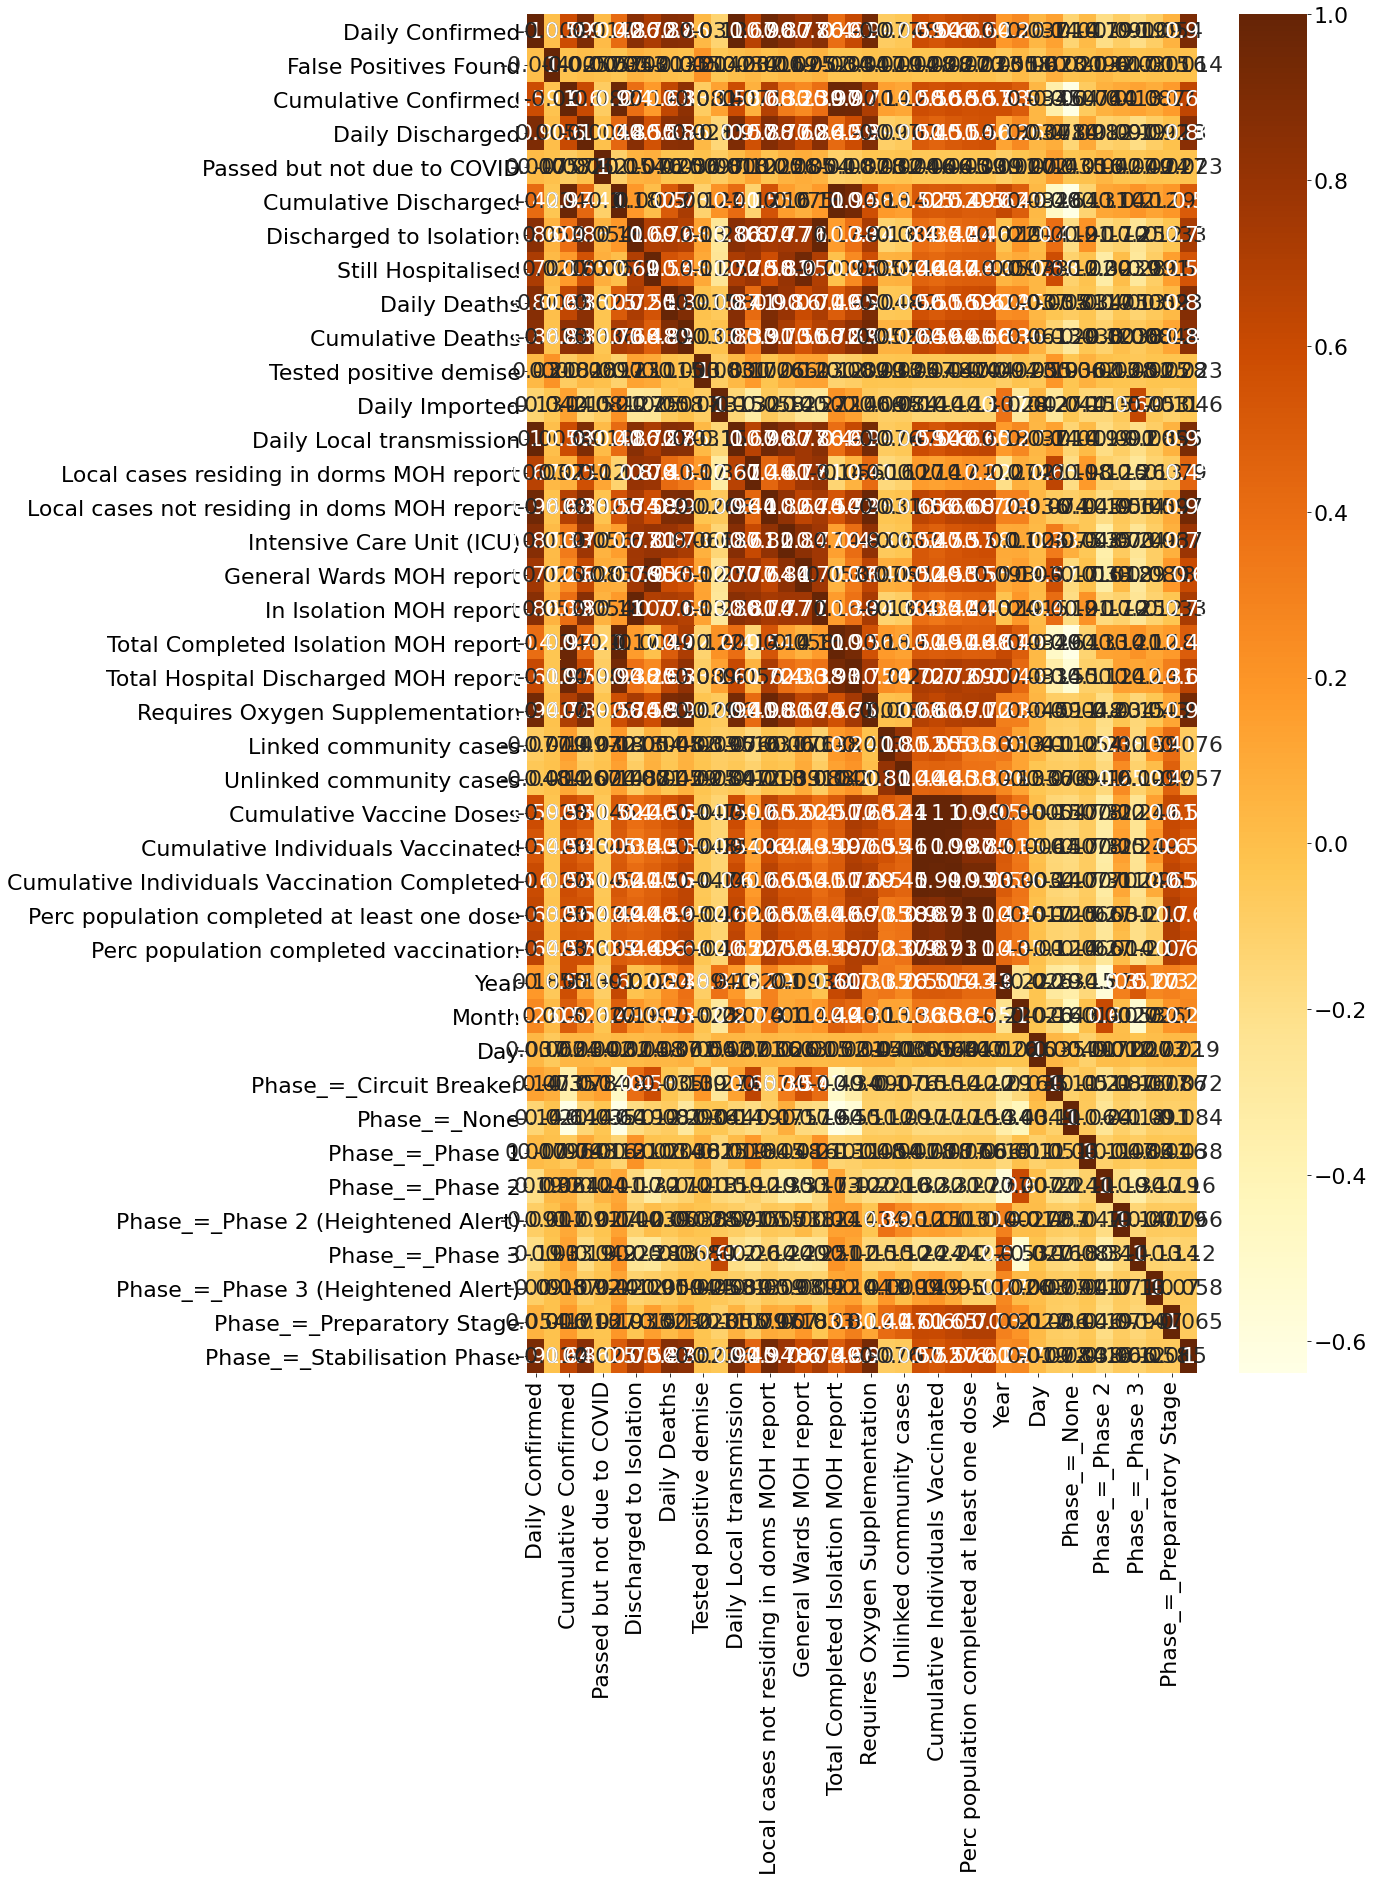

In [50]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [51]:
# understanding correlation of all variables to imported cases (can change accordingly to the variable you are trying to predict)

sg_data_filtered.corr()["Perc population completed vaccination"].sort_values(ascending=False)

Perc population completed vaccination           1.000000
Perc population completed at least one dose     0.998866
Cumulative Individuals Vaccination Completed    0.932059
Cumulative Vaccine Doses                        0.903348
Cumulative Individuals Vaccinated               0.866266
Requires Oxygen Supplementation                 0.724320
Total Hospital Discharged MOH report            0.701068
Local cases not residing in doms MOH report     0.698557
Phase_=_Preparatory Stage                       0.697830
Cumulative Deaths                               0.663865
Daily Local transmission                        0.645072
Daily Confirmed                                 0.644586
Phase_=_Stabilisation Phase                     0.611867
Daily Deaths                                    0.604574
Intensive Care Unit (ICU)                       0.579729
Cumulative Confirmed                            0.572779
Daily Discharged                                0.561044
General Wards MOH report       

In [52]:
# conduct PCA on preprocessed columns

# pca = PCA().fit(sg_data_filtered)

In [53]:
# pca.components_[0]

In [54]:
# find index of columns that make most contribution to variance captured

# include index of Daily Imported first
# important_indices = [11]

# for i in range(len(pca.components_[0])):
#     curr_comp = pca.components_[0][i]
#     if curr_comp > 0.0001:
#         important_indices.append(i)

In [55]:
# select the columns that are positively correlated to imported cases + PCA columns

# sg_data_final = sg_data_filtered.iloc[:, important_indices]

# Viewing Chart Pattern

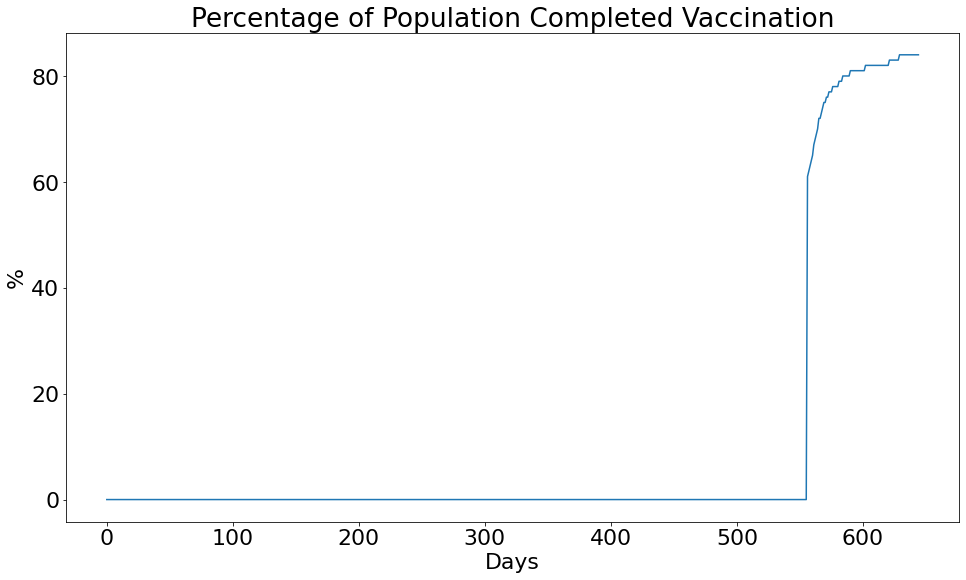

In [56]:
fig, ax = plt.subplots(figsize=(16,9))
sg_data_filtered["Perc population completed vaccination"].plot()
plt.title('Percentage of Population Completed Vaccination')
plt.xlabel('Days')
plt.ylabel('%')
plt.show()
fig.savefig('Percentage_of_Population_Completed_Vaccination.png')

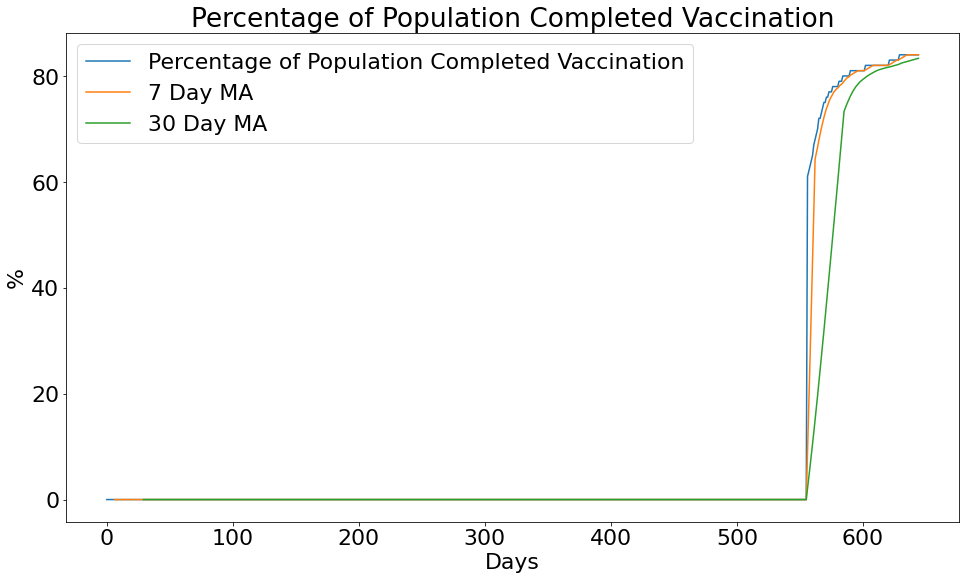

In [57]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(sg_data_filtered["Perc population completed vaccination"], label="Percentage of Population Completed Vaccination")
ax.plot(sg_data_filtered["Perc population completed vaccination"].rolling(window=7).mean(), label="7 Day MA")
ax.plot(sg_data_filtered["Perc population completed vaccination"].rolling(window=30).mean(), label="30 Day MA")
ax.legend()
plt.title('Percentage of Population Completed Vaccination')
plt.xlabel('Days')
plt.ylabel('%')
plt.show()
fig.savefig('Perc_population_completed_vaccination_with_moving_average.png')

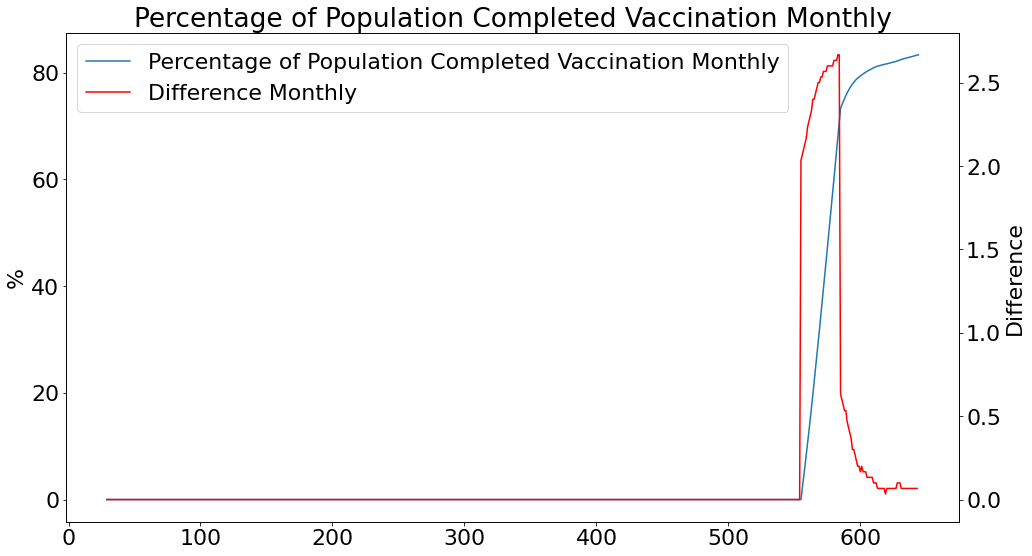

In [58]:
# shows inflection point
fig, ax = plt.subplots(figsize=(16,9))
ln1 = ax.plot(sg_data_filtered["Perc population completed vaccination"].rolling(window=30).mean(), label="Percentage of Population Completed Vaccination Monthly")
ax.set_ylabel("%")
ax2 = ax.twinx()
ln2 = ax2.plot(np.diff(sg_data_filtered["Perc population completed vaccination"].rolling(window=30).mean()), label="Difference Monthly", color="red")
ax2.set_ylabel("Difference")
ax.legend(ln1+ln2,[x.get_label() for x in (ln1 + ln2)])
plt.title('Percentage of Population Completed Vaccination Monthly')
plt.xlabel('Days')
plt.show()
fig.savefig('Perc_population_completed_vaccination_with_diff.png')

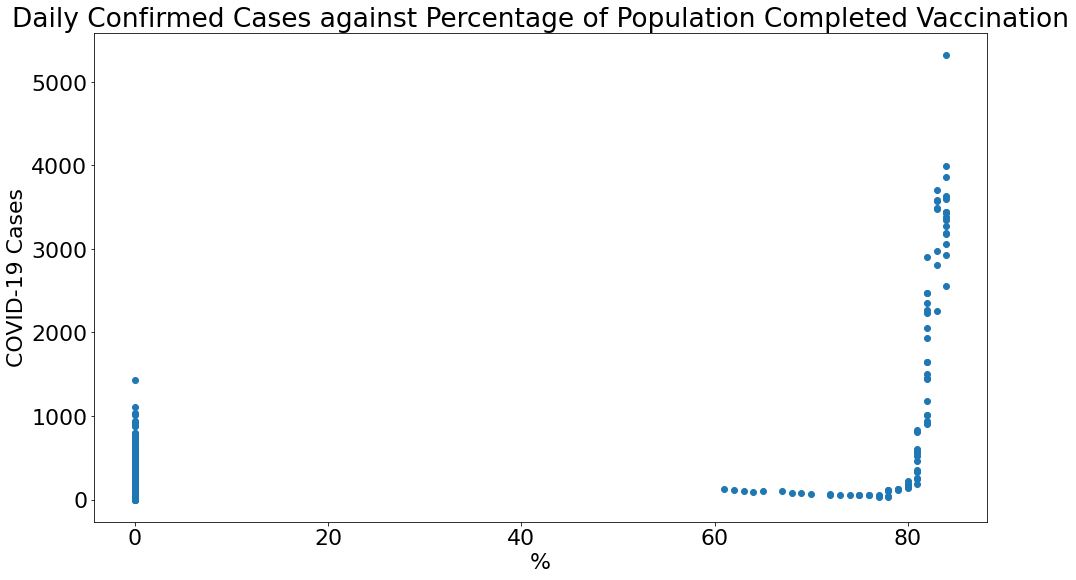

In [59]:
# Shall we use a constant rate of vaccination rate for the data we do not have? - imputation
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(sg_data_filtered["Perc population completed vaccination"],sg_data_filtered["Daily Confirmed"])
plt.title('Daily Confirmed Cases against Percentage of Population Completed Vaccination')
plt.xlabel('%')
plt.ylabel('COVID-19 Cases')
plt.show()
fig.savefig('Perc_population_completed_vaccination_scatter.png')

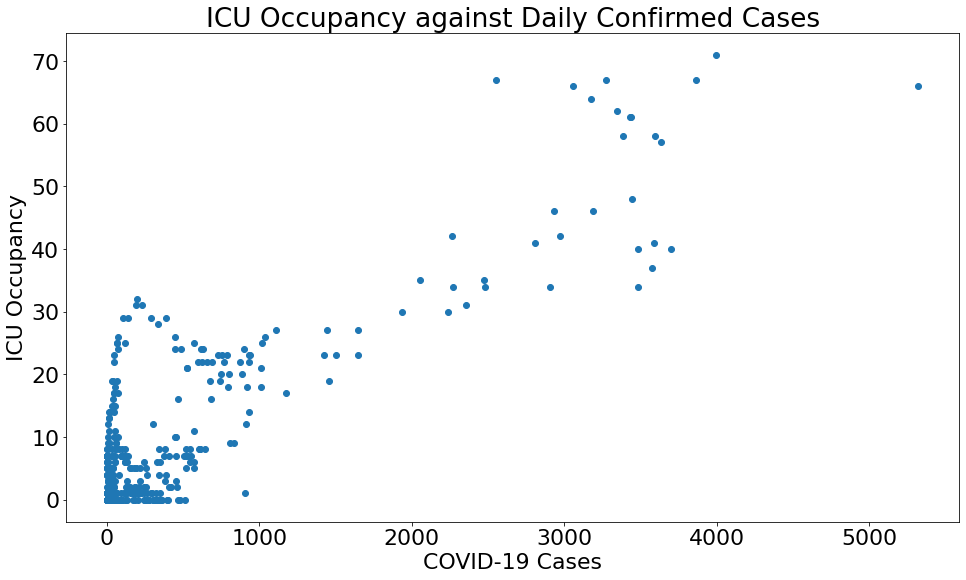

In [60]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(sg_data_filtered["Daily Confirmed"],sg_data_filtered["Intensive Care Unit (ICU)"])
plt.title('ICU Occupancy against Daily Confirmed Cases')
plt.xlabel('COVID-19 Cases')
plt.ylabel('ICU Occupancy')
plt.show()
fig.savefig('ICU_Occupancy_against_Daily_Confirmed_Cases_Scatter.png')

## Phases

In [61]:
sg_data_filtered["Phase"].unique()

array(['None', 'Circuit Breaker', 'Phase 1', 'Phase 2', 'Phase 3',
       'Phase 2 (Heightened Alert)', 'Phase 3 (Heightened Alert)',
       'Preparatory Stage', 'Stabilisation Phase'], dtype=object)

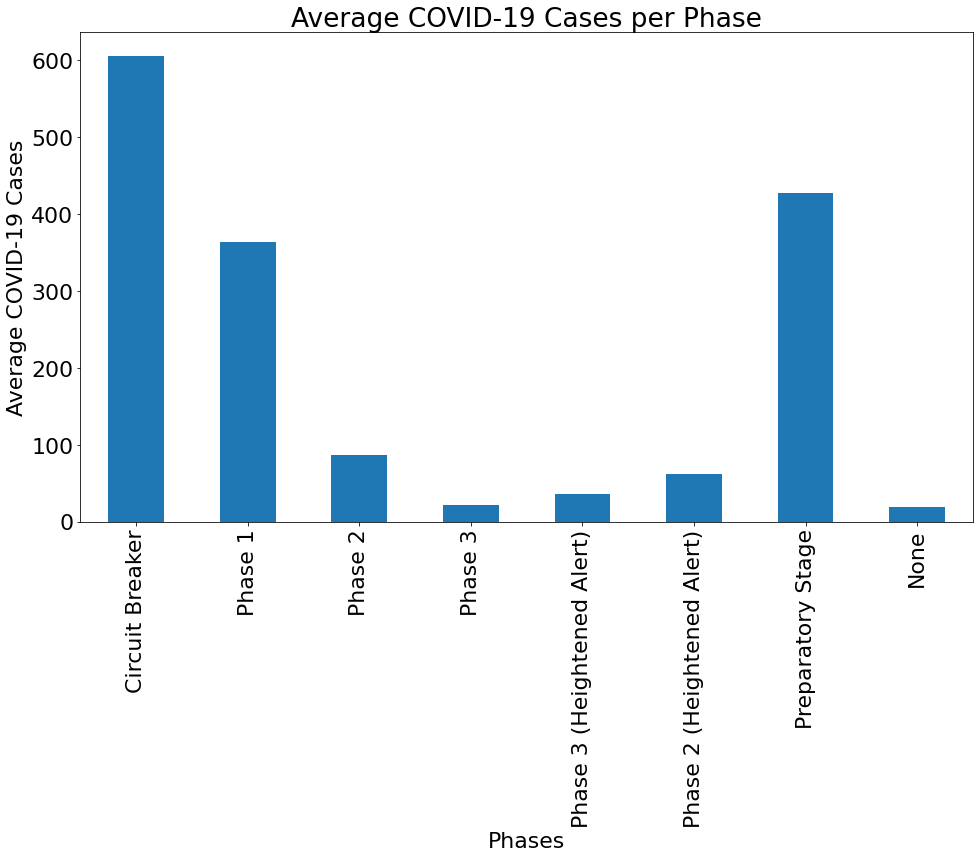

In [64]:
fig, ax = plt.subplots(figsize=(16,9))
temp = sg_data_filtered.copy()

phases = ['Circuit Breaker', 'Phase 1', 'Phase 2', 'Phase 3', 'Phase 3 (Heightened Alert)', 'Phase 2 (Heightened Alert)', 'Preparatory Stage', 'Stabilisation Phase','None']
# mapping = {phase: i for i, phase in enumerate(phases)}
# key = temp["Phase"].map(mapping)
temp = temp.groupby('Phase')["Daily Confirmed"].mean()
# temp.iloc[key.argsort()]
#temp.drop("Stabilisation Phase",inplace=True)
temp.reindex(phases).plot.bar()
plt.title('Average COVID-19 Cases per Phase')
plt.xlabel('Phases')
plt.ylabel('Average COVID-19 Cases')
plt.show()
fig.savefig('Average_Cases_per_phase.png')